In [1]:
from jaxl.constants import *
from jaxl.datasets import get_dataset
from jaxl.learning_utils import get_learner
from jaxl.utils import parse_dict

import jax
import json
import numpy as np
import optax
import os

from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager

In [2]:
base_dir = "/Users/chanb/research/personal/jaxl/jaxl"
learner_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/icl-noiseless-no_bias-2d_linear-active_dim_2-full_context_16/gpt-pos_enc-09-09-23_15_09_55-0c965292-9e2e-4268-87df-3221b558bb19"
test_dataset_seed = 999

In [3]:
config_path = os.path.join(learner_path, "config.json")
with open(config_path, "r") as f:
    config_dict = json.load(f)
    config = parse_dict(config_dict)

learner = get_learner(
    config.learner_config, config.model_config, config.optimizer_config
)

checkpoint_manager = CheckpointManager(
    os.path.join(learner_path, "models"),
    PyTreeCheckpointer(),
)

params = checkpoint_manager.restore(checkpoint_manager.latest_step())
params[CONST_MODEL_DICT][CONST_MODEL][CONST_POSITIONAL_ENCODING] = dict()
model = learner._model

In [4]:
config.learner_config.dataset_config

namespace(dataset_name='multitask_nd_linear_classification',
          dataset_kwargs=namespace(input_dim=2,
                                   num_sequences=100000,
                                   sequence_length=41,
                                   noise=0.0,
                                   params_bound=[-10.0, 10.0],
                                   num_active_params=None,
                                   val_frac=0.0005),
          dataset_wrapper=namespace(type='ContextDataset',
                                    kwargs=namespace(context_len=16)))

In [5]:
sequence_len = 80
input_range = [-1.0, 1.0]
test_config = vars(config.learner_config.dataset_config)
test_config["dataset_kwargs"] = vars(test_config["dataset_kwargs"])
test_config["dataset_kwargs"]["num_sequences"] = 1
test_config["dataset_kwargs"]["sequence_length"] = sequence_len + 1
test_config["dataset_kwargs"]["params_bound"] = [-0.5, 0.5]
test_config["dataset_kwargs"]["inputs_range"] = input_range
ns_test_config = parse_dict(test_config)

In [6]:
test_dataset = get_dataset(ns_test_config, seed=test_dataset_seed)
unwrapped_dataset = test_dataset._dataset

In [7]:
test_dataset[0][3].shape

(2,)

In [8]:
print(unwrapped_dataset._inputs.shape, unwrapped_dataset._targets.shape)

(1, 81, 2) (1, 81, 2)


In [9]:
context_len = config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len


def get_result(dataset, context_len):
    context_inputs, context_outputs = [], []
    for context_i in range(context_len):
        context_inputs.append(dataset._inputs[0, context_i])
        context_outputs.append(dataset._targets[0, context_i])
    context_inputs = np.stack(context_inputs)
    context_outputs = np.stack(context_outputs)

    queries = dataset._inputs[0, context_len:]
    outputs = dataset._targets[0, context_len:]

    preds, _ = jax.vmap(model.forward, in_axes=[None, 0, None])(
        params[CONST_MODEL_DICT][CONST_MODEL],
        queries[:, None, None],
        {
            CONST_CONTEXT_INPUT: context_inputs[None, :],
            CONST_CONTEXT_OUTPUT: context_outputs[None, :],
        },
    )
    return queries, preds, outputs, context_inputs, context_outputs

In [10]:
def ce_loss(logits, y_one_hot):
    return np.mean(optax.softmax_cross_entropy(logits, y_one_hot))

In [11]:
queries, preds, outputs, context_inputs, context_outputs = get_result(
    unwrapped_dataset, context_len
)
preds = preds[:, 0]
loss = ce_loss(preds, outputs)
print(queries.shape, preds.shape, outputs.shape)

(65, 2) (65, 2) (65, 2)


In [12]:
loss

Array(0.10686142, dtype=float32)

# Analysis

In [13]:
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [14]:
gt = test_dataset.params[0]
gt_out = -np.array(input_range) * gt[1] / gt[2]

### SVM

In [18]:
svm = make_pipeline(
    LinearSVC(
        dual="auto",
        loss="hinge",
        random_state=0,
        tol=1e-7,
        C=100.0,
    ),
)
svm.fit(context_inputs, np.argmax(context_outputs, axis=1))

Pipeline(steps=[('linearsvc',
                 LinearSVC(C=100.0, dual='auto', loss='hinge', random_state=0,
                           tol=1e-07))])

(-1.0, 1.0)

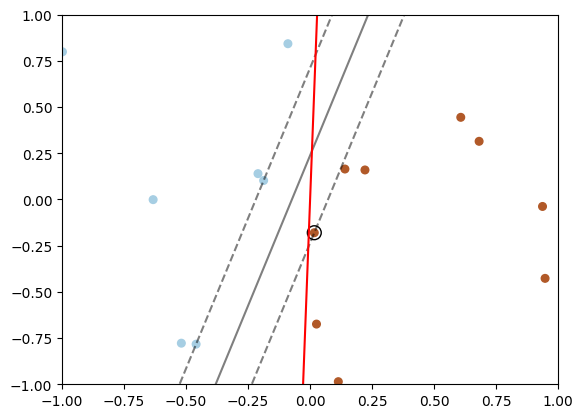

In [19]:
decision_function = svm.decision_function(context_inputs)
support_vector_indices = np.where(np.abs(decision_function) <= 1)[0]
support_vectors = context_inputs[support_vector_indices]

plt.scatter(
    context_inputs[:, 0],
    context_inputs[:, 1],
    c=context_outputs[:, -1],
    s=30,
    cmap=plt.cm.Paired,
)
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    svm,
    context_inputs,
    ax=ax,
    grid_resolution=50,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["--", "-", "--"],
)
plt.scatter(
    support_vectors[:, 0],
    support_vectors[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.plot(np.array(input_range), gt_out, label="Ground truth", color="red")
plt.xlim(input_range[0], input_range[1])
plt.ylim(input_range[0], input_range[1])

### Logistic Regression

In [20]:
logistic_regression = make_pipeline(LogisticRegression(penalty="l2"))
logistic_regression.fit(context_inputs, np.argmax(context_outputs, axis=1))

Pipeline(steps=[('logisticregression', LogisticRegression())])

(-1.0, 1.0)

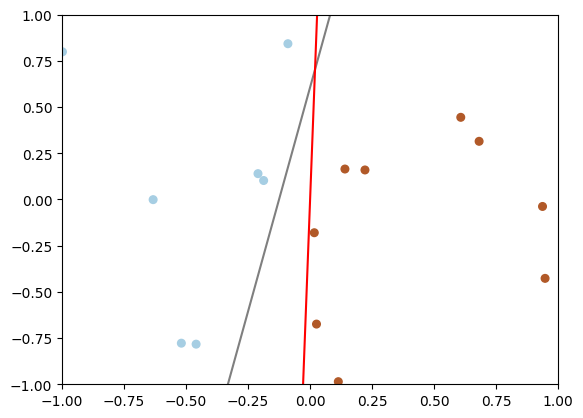

In [23]:
plt.scatter(
    context_inputs[:, 0],
    context_inputs[:, 1],
    c=context_outputs[:, -1],
    s=30,
    cmap=plt.cm.Paired,
)
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    logistic_regression,
    context_inputs,
    ax=ax,
    grid_resolution=50,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    linestyles=["-"],
)
plt.plot(np.array(input_range), gt_out, label="Ground truth", color="red")
plt.xlim(input_range[0], input_range[1])
plt.ylim(input_range[0], input_range[1])

### ICL Analysis

In [29]:
svm_out = (
    -(np.array(input_range) * svm[0].coef_[0, 0] + svm[0].intercept_[0])
    / svm[0].coef_[0, 1]
)
lr_out = (
    -(
        np.array(input_range) * logistic_regression[0].coef_[0, 0]
        + logistic_regression[0].intercept_[0]
    )
    / logistic_regression[0].coef_[0, 1]
)

Text(0, 0.5, '$x_2$')

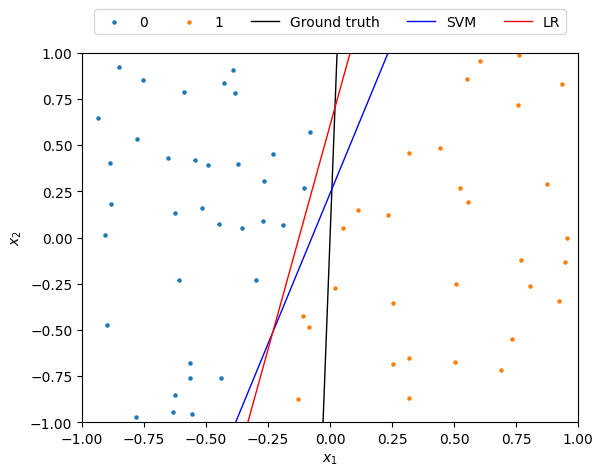

In [34]:
pred_labels = np.argmax(preds, axis=-1)
for possible_label in [0, 1]:
    idxes = np.where(pred_labels == possible_label)
    plt.scatter(
        queries[idxes][:, 0],
        queries[idxes][:, 1],
        label=f"{possible_label}",
        s=5,
    )

plt.plot(
    np.array(input_range), gt_out, label="Ground truth", color="black", linewidth=1
)

plt.plot(np.array(input_range), svm_out, label="SVM", color="blue", linewidth=1)

plt.plot(np.array(input_range), lr_out, label="LR", color="red", linewidth=1)

plt.xlim(input_range[0], input_range[1])
plt.ylim(input_range[0], input_range[1])
plt.legend(
    bbox_to_anchor=(0.0, 1.05, 1.0, 0.0),
    loc="lower center",
    ncols=5,
    borderaxespad=0.0,
    frameon=True,
)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

In [54]:
x_grid = np.arange(-0.5, 0.5, 0.02).repeat(10)
print(x_grid.shape)

svm_y = (
    -(np.array(x_grid) * svm[0].coef_[0, 0] + svm[0].intercept_[0]) / svm[0].coef_[0, 1]
) + jax.random.normal(jax.random.PRNGKey(0), x_grid.shape)

svm_queries = np.vstack((x_grid, svm_y)).T

(500,)


In [55]:
svm_preds, _ = jax.vmap(model.forward, in_axes=[None, 0, None])(
    params[CONST_MODEL_DICT][CONST_MODEL],
    svm_queries[:, None, None],
    {
        CONST_CONTEXT_INPUT: context_inputs[None, :],
        CONST_CONTEXT_OUTPUT: context_outputs[None, :],
    },
)
svm_preds = svm_preds[:, 0]

Text(0, 0.5, '$x_2$')

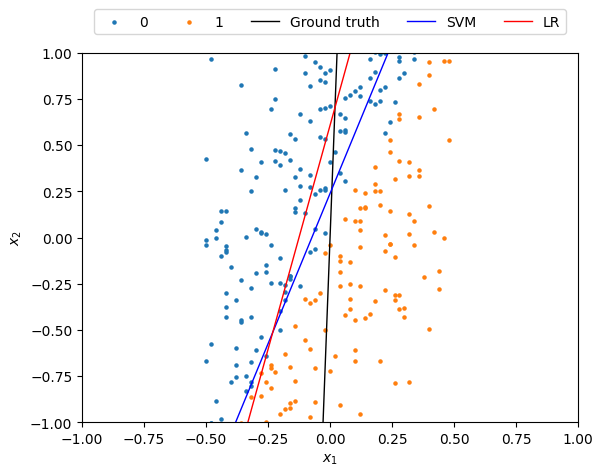

In [56]:
svm_pred_labels = np.argmax(svm_preds, axis=-1)
for possible_label in [0, 1]:
    idxes = np.where(svm_pred_labels == possible_label)
    plt.scatter(
        svm_queries[idxes][:, 0],
        svm_queries[idxes][:, 1],
        label=f"{possible_label}",
        s=5,
    )

plt.plot(
    np.array(input_range), gt_out, label="Ground truth", color="black", linewidth=1
)

plt.plot(np.array(input_range), svm_out, label="SVM", color="blue", linewidth=1)

plt.plot(np.array(input_range), lr_out, label="LR", color="red", linewidth=1)

plt.xlim(input_range[0], input_range[1])
plt.ylim(input_range[0], input_range[1])
plt.legend(
    bbox_to_anchor=(0.0, 1.05, 1.0, 0.0),
    loc="lower center",
    ncols=5,
    borderaxespad=0.0,
    frameon=True,
)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")